In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Change figure size configuration
plt.rcParams['figure.figsize'] = (11, 4)

# Loading Data

In [39]:
traindata = pd.read_csv("traindata.csv")
testdata = pd.read_csv("testdata.csv")

In [40]:
y = traindata.Class
traindata.drop('Class',axis=1,inplace=True)

Concatnate train and test together 

In [41]:
df_data =  pd.concat([traindata,testdata])
df_data.reset_index(inplace=True, drop=True)

In [42]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45503 entries, 0 to 45502
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45503 non-null  int64  
 1   duration                     45503 non-null  int64  
 2   protocol_type                45503 non-null  object 
 3   service                      45503 non-null  object 
 4   flag                         45503 non-null  object 
 5   src_bytes                    45503 non-null  int64  
 6   dst_bytes                    45503 non-null  int64  
 7   land                         45503 non-null  int64  
 8   wrong_fragment               45503 non-null  int64  
 9   urgent                       45503 non-null  int64  
 10  hot                          45503 non-null  int64  
 11  num_failed_logins            45503 non-null  int64  
 12  logged_in                    45503 non-null  int64  
 13  num_compromised 

In [43]:
#drop id
df_data.drop('ID',inplace=True,axis=1)

Check if there constante columns and drop it

In [44]:
res = []
for c in df_data.columns:
    res.append((c,len(traindata[c].unique())))
res = pd.DataFrame(res,columns=['name','value']).sort_values(by='value')

In [45]:
dd = res[res.value < 2]['name']

df_data.drop(dd ,axis=1 ,inplace=True)

In [46]:
dd

20        is_host_login
19    num_outbound_cmds
Name: name, dtype: object

Check for columns that contains zeros less than 30% and drop the rest

In [47]:
zeros_df = df_data.astype(bool).sum(axis=0)
zeros_df[zeros_df>(df_data.shape[0]*30/100)]

protocol_type                  45503
service                        45503
flag                           45503
src_bytes                      28685
dst_bytes                      23544
logged_in                      18842
count                          45502
srv_count                      45502
same_srv_rate                  44246
diff_srv_rate                  15977
dst_host_count                 45501
dst_host_srv_count             45501
dst_host_same_srv_rate         42850
dst_host_diff_srv_rate         27972
dst_host_same_src_port_rate    21157
level                          45369
dtype: int64

In [48]:
s_cols=zeros_df[zeros_df>(df_data.shape[0]*30/100)].index
df_data=df_data[s_cols]

Encoding categorical features using label encoder

In [49]:
df_data.select_dtypes(include=['object'])

,protocol_type,service,flag
0,tcp,http,SF
1,tcp,http,SF
2,tcp,ftp,SF
3,tcp,http,SF
4,tcp,X11,REJ
...,...,...,...
45498,tcp,http,SF
45499,tcp,ftp,SF
45500,tcp,private,S0
45501,tcp,http,SF


In [50]:
trainnum =df_data.drop(['protocol_type'	,'service'	,'flag'],axis=1)
for c in trainnum.columns:
    df_data[c] = (df_data[c]-df_data[c].min())/df_data[c].std()

<AxesSubplot:>

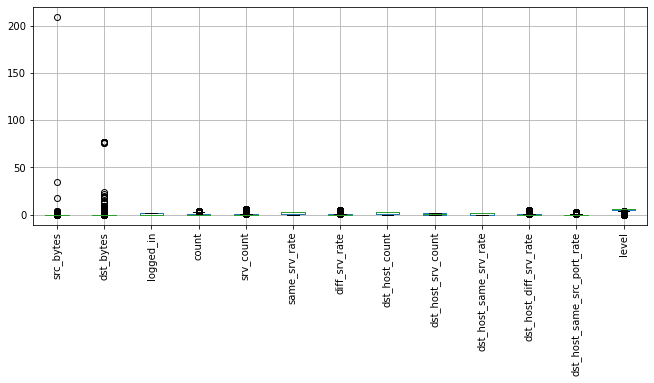

In [51]:
df_data.boxplot(rot=90)

<AxesSubplot:>

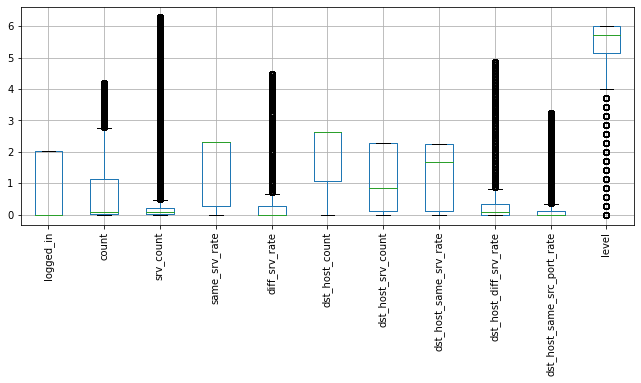

In [52]:
df_data.drop(['src_bytes','dst_bytes'],axis=1,inplace=False).boxplot(rot=90)

In [53]:
df_data.drop(['src_bytes','dst_bytes'],axis=1,inplace=False).describe()

,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,level
count,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000,45503.000000
mean,0.840660,0.677142,0.362110,1.618635,0.352442,1.954891,1.132266,1.257756,0.425211,0.455173,5.349214
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.016375,0.024626,0.279165,0.000000,1.056520,0.107206,0.112333,0.000000,0.000000,5.135031
50%,0.000000,0.090064,0.086190,2.326372,0.000000,2.641300,0.857650,1.684989,0.097207,0.000000,5.705590
75%,2.030175,1.121709,0.209318,2.326372,0.268893,2.641300,2.278133,2.246652,0.340226,0.129908,5.990869
max,2.030175,4.183891,6.291842,2.326372,4.481546,2.641300,2.278133,2.246652,4.860365,3.247689,5.990869


In [54]:
#taking the log of high variance columns 
log_cols = ['src_bytes','dst_bytes','count','srv_count','dst_host_count','dst_host_srv_count']

df_data[c] = np.log10(df_data[c]+1)

Encoding categorical fearures

In [55]:
traincat =df_data.select_dtypes(include=['object'])
for c in traincat.columns:
    df_data[c] = LabelEncoder().fit_transform(df_data[c])

In [56]:
df_data

,protocol_type,service,flag,src_bytes,dst_bytes,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,level
0,1,22,9,0.000162,0.038387,2.030175,0.016375,0.036938,2.326372,0.000000,1.046162,2.278133,2.246652,0.000000,0.032477,0.844531
1,1,22,9,0.000171,0.012464,2.030175,0.040938,0.086190,2.326372,0.000000,2.309842,2.278133,2.246652,0.000000,0.000000,0.844531
2,1,18,9,0.000672,0.036412,2.030175,0.008188,0.012313,2.326372,0.000000,2.641300,1.036327,1.010993,0.097207,0.000000,0.616798
3,1,22,9,0.000161,0.004397,2.030175,0.024563,0.049251,2.326372,0.000000,2.237336,2.278133,2.246652,0.000000,0.000000,0.844531
4,1,1,1,0.000000,0.000000,0.000000,0.016375,0.012313,1.163186,4.481546,1.191174,0.008934,0.022467,0.145811,0.032477,0.616798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45498,1,22,9,0.000163,0.033396,2.030175,0.171941,0.258569,2.326372,0.000000,1.740150,2.278133,2.246652,0.000000,0.032477,0.844531
45499,1,18,9,0.000088,0.008899,2.030175,0.008188,0.012313,2.326372,0.000000,1.698718,0.491362,0.763862,0.194415,0.032477,0.616798
45500,1,46,5,0.000000,0.000000,0.000000,1.211773,0.221630,0.279165,0.268893,2.641300,0.160809,0.157266,0.291622,0.000000,0.844531
45501,1,22,9,0.000109,0.165003,2.030175,0.008188,0.012313,2.326372,0.000000,0.186445,2.278133,2.246652,0.000000,0.194861,0.844531


0 Mean Normlization 

In [57]:
scaler = StandardScaler().fit(df_data[trainnum.columns]) 
sc_train = scaler.transform(df_data[trainnum.columns])
sc_traindf = pd.DataFrame(sc_train, columns = trainnum.columns)

In [58]:
df_data

,protocol_type,service,flag,src_bytes,dst_bytes,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,level
0,1,22,9,0.000162,0.038387,2.030175,0.016375,0.036938,2.326372,0.000000,1.046162,2.278133,2.246652,0.000000,0.032477,0.844531
1,1,22,9,0.000171,0.012464,2.030175,0.040938,0.086190,2.326372,0.000000,2.309842,2.278133,2.246652,0.000000,0.000000,0.844531
2,1,18,9,0.000672,0.036412,2.030175,0.008188,0.012313,2.326372,0.000000,2.641300,1.036327,1.010993,0.097207,0.000000,0.616798
3,1,22,9,0.000161,0.004397,2.030175,0.024563,0.049251,2.326372,0.000000,2.237336,2.278133,2.246652,0.000000,0.000000,0.844531
4,1,1,1,0.000000,0.000000,0.000000,0.016375,0.012313,1.163186,4.481546,1.191174,0.008934,0.022467,0.145811,0.032477,0.616798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45498,1,22,9,0.000163,0.033396,2.030175,0.171941,0.258569,2.326372,0.000000,1.740150,2.278133,2.246652,0.000000,0.032477,0.844531
45499,1,18,9,0.000088,0.008899,2.030175,0.008188,0.012313,2.326372,0.000000,1.698718,0.491362,0.763862,0.194415,0.032477,0.616798
45500,1,46,5,0.000000,0.000000,0.000000,1.211773,0.221630,0.279165,0.268893,2.641300,0.160809,0.157266,0.291622,0.000000,0.844531
45501,1,22,9,0.000109,0.165003,2.030175,0.008188,0.012313,2.326372,0.000000,0.186445,2.278133,2.246652,0.000000,0.194861,0.844531


In [59]:
sc_traindf

,src_bytes,dst_bytes,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,level
0,-0.009828,-0.003679,1.189528,-0.660774,-0.325175,0.707744,-0.352446,-0.908739,1.145880,0.988907,-0.425216,-0.422701,0.511265
1,-0.009819,-0.029602,1.189528,-0.636211,-0.275923,0.707744,-0.352446,0.354955,1.145880,0.988907,-0.425216,-0.455178,0.511265
2,-0.009318,-0.005654,1.189528,-0.668962,-0.349801,0.707744,-0.352446,0.686416,-0.095939,-0.246765,-0.328007,-0.455178,-1.803710
3,-0.009829,-0.037669,1.189528,-0.652587,-0.312862,0.707744,-0.352446,0.282448,1.145880,0.988907,-0.425216,-0.455178,0.511265
4,-0.009990,-0.042066,-0.840669,-0.660774,-0.349801,-0.455454,4.129150,-0.763725,-1.123344,-1.235303,-0.279403,-0.422701,-1.803710
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45498,-0.009826,-0.008670,1.189528,-0.505207,-0.103542,0.707744,-0.352446,-0.214743,1.145880,0.988907,-0.425216,-0.422701,0.511265
45499,-0.009902,-0.033168,1.189528,-0.668962,-0.349801,0.707744,-0.352446,-0.256175,-0.640911,-0.493899,-0.230799,-0.422701,-1.803710
45500,-0.009990,-0.042066,-0.840669,0.534636,-0.140481,-1.339485,-0.083550,0.686416,-0.971467,-1.100502,-0.133591,-0.455178,0.511265
45501,-0.009881,0.122939,1.189528,-0.668962,-0.349801,0.707744,-0.352446,-1.768466,1.145880,0.988907,-0.425216,-0.260315,0.511265


In [60]:
sc_traindf = pd.concat([sc_traindf,df_data[['protocol_type'	,'service'	,'flag']]],axis=1)

In [61]:
sc_traindf

,src_bytes,dst_bytes,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,level,protocol_type,service,flag
0,-0.009828,-0.003679,1.189528,-0.660774,-0.325175,0.707744,-0.352446,-0.908739,1.145880,0.988907,-0.425216,-0.422701,0.511265,1,22,9
1,-0.009819,-0.029602,1.189528,-0.636211,-0.275923,0.707744,-0.352446,0.354955,1.145880,0.988907,-0.425216,-0.455178,0.511265,1,22,9
2,-0.009318,-0.005654,1.189528,-0.668962,-0.349801,0.707744,-0.352446,0.686416,-0.095939,-0.246765,-0.328007,-0.455178,-1.803710,1,18,9
3,-0.009829,-0.037669,1.189528,-0.652587,-0.312862,0.707744,-0.352446,0.282448,1.145880,0.988907,-0.425216,-0.455178,0.511265,1,22,9
4,-0.009990,-0.042066,-0.840669,-0.660774,-0.349801,-0.455454,4.129150,-0.763725,-1.123344,-1.235303,-0.279403,-0.422701,-1.803710,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45498,-0.009826,-0.008670,1.189528,-0.505207,-0.103542,0.707744,-0.352446,-0.214743,1.145880,0.988907,-0.425216,-0.422701,0.511265,1,22,9
45499,-0.009902,-0.033168,1.189528,-0.668962,-0.349801,0.707744,-0.352446,-0.256175,-0.640911,-0.493899,-0.230799,-0.422701,-1.803710,1,18,9
45500,-0.009990,-0.042066,-0.840669,0.534636,-0.140481,-1.339485,-0.083550,0.686416,-0.971467,-1.100502,-0.133591,-0.455178,0.511265,1,46,5
45501,-0.009881,0.122939,1.189528,-0.668962,-0.349801,0.707744,-0.352446,-1.768466,1.145880,0.988907,-0.425216,-0.260315,0.511265,1,22,9


Separt training and testing data sets

In [62]:
X = sc_traindf.iloc[:23002,:]

In [63]:
X_t = sc_traindf.iloc[23002:,:]

Perform feature importance

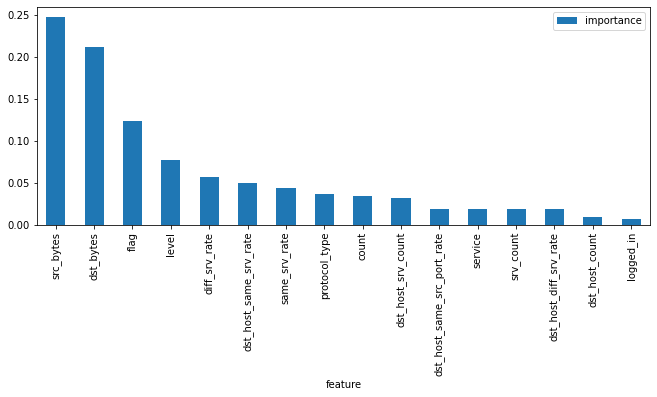

In [64]:
rfc = RandomForestClassifier(random_state=0);
rfc.fit(X, y);
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar();

In [65]:
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X, y)
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'level',
 'protocol_type',
 'flag']

In [66]:
X=X[selected_features]
X_t = X_t[selected_features]

Choosing the best parameters of Decision tree

In [67]:
params = {'ccp_alpha': list(np.arange(0.01,0.1,0.01)),'max_depth':[3,4,5],'min_samples_split':[2,3,4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X, y)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.01, 0.02, 0.03, 0.04, 0.05,
                                       0.060000000000000005,
                                       0.06999999999999999, 0.08, 0.09],
                         'max_depth': [3, 4, 5],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [68]:
grid_search_cv.best_params_

{'ccp_alpha': 0.01, 'max_depth': 3, 'min_samples_split': 2}

In [69]:
clf = DecisionTreeClassifier(random_state=0,ccp_alpha= 0.01,max_depth= 3,min_samples_split= 2).fit(X,y)
clf.score(X,y)

0.96874184853491

Testing decision tree on different features

Removing 'dst_host_srv_count' because it has lest importance score based on rendom forest graph

In [70]:
selected_features=['src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_same_srv_rate',
 'protocol_type',
 'flag',
 'level']

In [71]:
X=X[selected_features]
X_t = X_t[selected_features]

In [72]:
clf = DecisionTreeClassifier(random_state=0,ccp_alpha= 0.01,max_depth= 3,min_samples_split= 2).fit(X,y)
clf.score(X,y)

0.981262498913138

As we see after removing 'dst_host_srv_count' the model fitted the training data more <br>
with score from 0.96874184853491 to 0.981262498913138

In [73]:
preds = clf.predict(X_t)

Prepare submition File 

In [74]:
s = pd.read_csv("sampleSubmission.csv",index_col=False)
s['Class']= preds
s.to_csv('Submission.csv',index=False)